In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [ ]:
from brian2 import *

## Integrate-and-fire neuron model


This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.


In [ ]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [ ]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

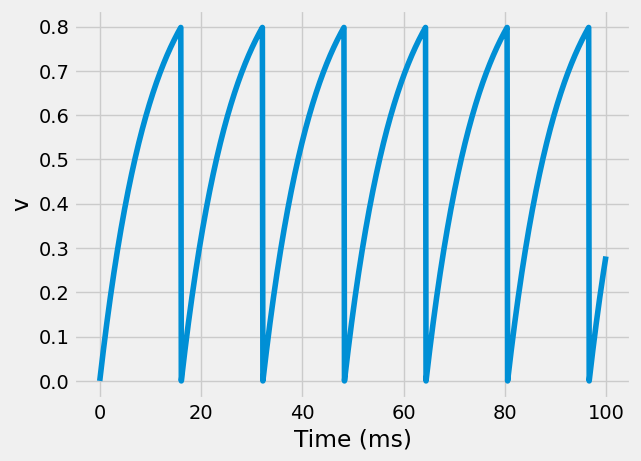

In [ ]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model


In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.


The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it.


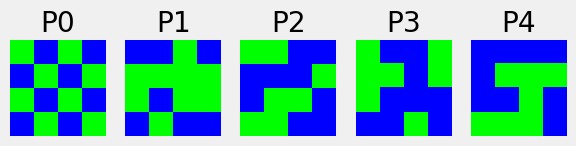

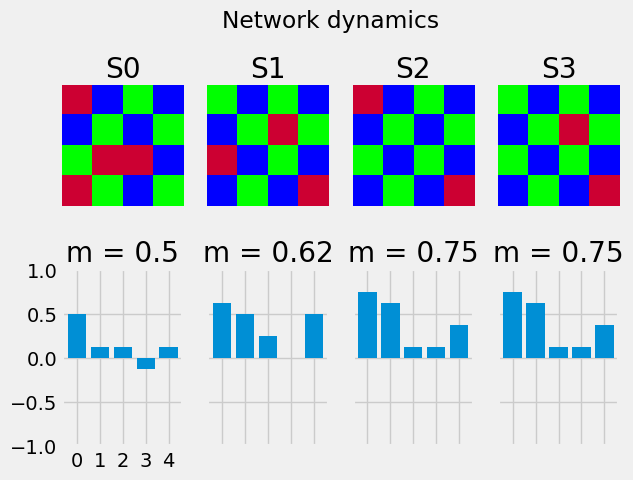

In [ ]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Q1

## Our own Hopfield network model


You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide.


Functions for the Hopfield network

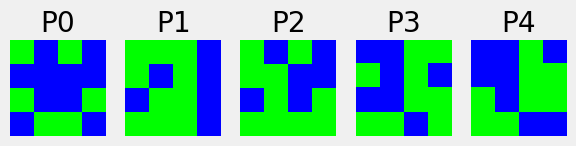

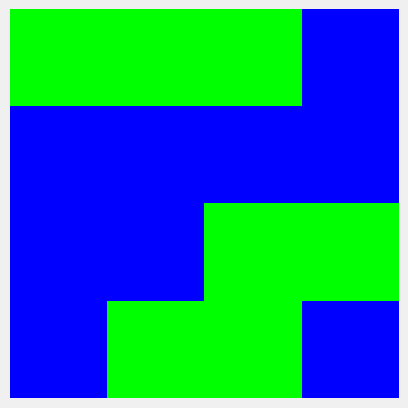

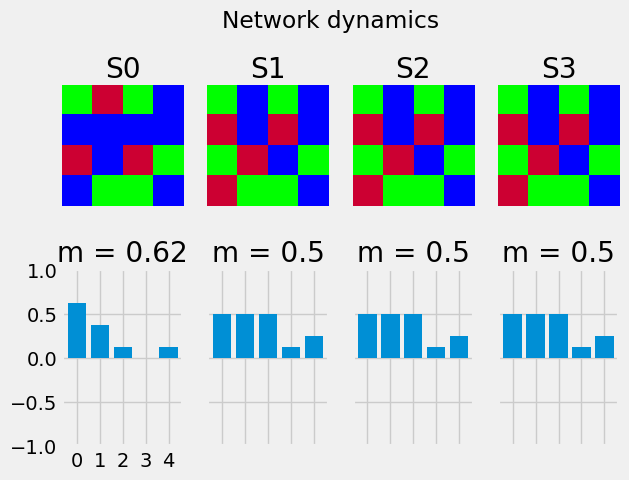

In [ ]:
def get_patterns(pattern_size, num_patterns):
    patterns = []
    for _ in range(num_patterns):
        pattern = np.random.choice([1, -1], size=(pattern_size, pattern_size))
        patterns.append(pattern)
    return patterns

# Function to perturb a pattern by flipping 'n' random bits
def perturb_pattern(pattern, num_flips):
    perturbed = np.array(pattern).flatten()
    indices_to_flip = np.random.choice(len(perturbed), num_flips, replace=False)
    perturbed[indices_to_flip] *= -1
    return perturbed.reshape(pattern.shape)

# Function to calculate the weights using the Hebbian learning rule
def calculate_weights(patterns, size):
    num_elements = size * size
    weight_matrix = np.zeros((num_elements, num_elements))

    for pattern in patterns:
        flattened = pattern.flatten()
        weight_matrix += np.outer(flattened, flattened)

    np.fill_diagonal(weight_matrix, 0)
    return weight_matrix / num_elements

def network_evolution(state, weights):
    flat_state = state.flatten()
    new_state = np.dot(weights, flat_state)
    evolved_state = np.sign(new_state)
    return evolved_state.reshape(state.shape)

plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")





## Assignment 1


Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points)


## Q2

#Varying the Informativeness of the Cue (a)


You can adjust it by varying the number of perturbations in the initial cue. A higher number of perturbations or flips results in lower informativeness of the cue.

Let's determine the model's ability to retrieve the correct pattern by varying the number of perturbations from 1 to 100.

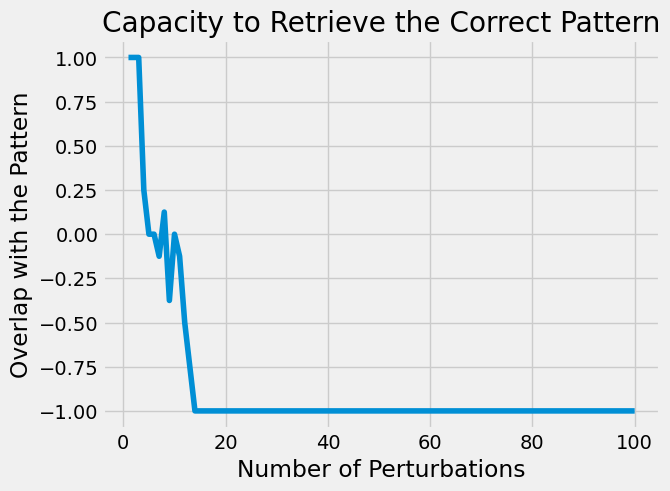

In [ ]:


accuracies = []
flip_values = [1, 3, 5, 7]

for flips in flip_values:
    S = perturb_pattern(cue[0], flips)
    state_list = [S]
    for _ in range(3):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    # Compute the accuracy (overlap with the original pattern)
    final_overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    accuracies.append(final_overlap)

    # Plot the state sequence and overlap for each flip value
   # plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle=f"Network dynamics with {flips} flips")

# After the loop, plot the accuracy vs. informativeness (number of flips)
# plt.figure()
# plt.plot(flip_values, accuracies, marker='o')
# plt.xlabel('Number of Flips (Cue Informativeness)')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Cue Informativeness')
# plt.show()

overlaps = []

perturb_nums = range(1, 101)  # Increase the number of perturbations to 100
pattern_size = cue[0].size  # Get the total number of elements in the pattern

for num_flips in perturb_nums:
    flips = min(num_flips, pattern_size)  # Ensure num_flips doesn't exceed the number of elements
    S = perturb_pattern(cue[0], flips)
    state_list = [S]

    # Evolve the state over 3 iterations
    for _ in range(3):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    # Compute the overlap with the original pattern
    final_overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    overlaps.append(final_overlap)

# Plot the capacity to retrieve the correct pattern as a function of the number of perturbations
plt.title("Capacity to Retrieve the Correct Pattern")
plt.xlabel('Number of Perturbations')
plt.ylabel('Overlap with the Pattern')
plt.plot(perturb_nums, overlaps)

plt.show()



Increasing perturbations decreases accuracy because the more you change the cue, the less it looks like the original pattern. This makes it harder for the network to find and recover the correct pattern, leading to lower overlap and accuracy.

#Varying the Number of Stored Patterns (b)


Let's adjust the number of patterns from 1 to 100.

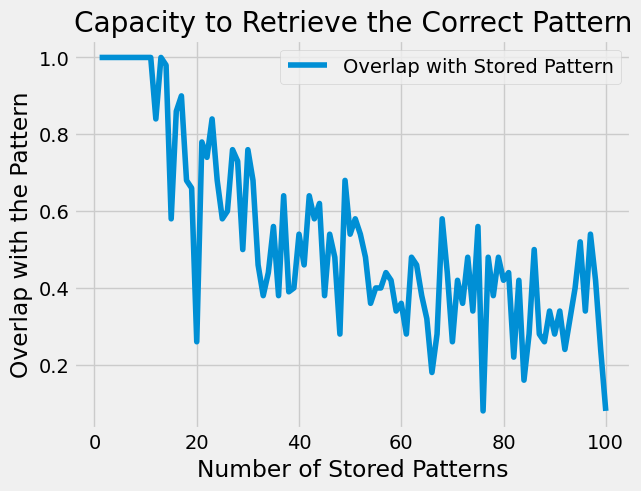

In [ ]:


accuracies = []
pattern_counts = [2, 5, 10, 15]

for num_patterns in pattern_counts:
    plist = get_patterns(pattern_size, num_patterns)
    wghts = calculate_weights(plist, pattern_size)
    S = perturb_pattern(plist[0], 3)
    state_list = [S]
    for _ in range(3):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    # Compute the accuracy (overlap with the original pattern)
    final_overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    accuracies.append(final_overlap)

    # Plot the state sequence and overlap for each number of patterns stored
    #plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle=f"Network dynamics with {num_patterns} patterns stored")

# After the loop, plot the accuracy vs. the number of stored patterns
# plt.figure()
# plt.plot(pattern_counts, accuracies, marker='o')
# plt.xlabel('Number of Stored Patterns')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Number of Stored Patterns')
# plt.show()

def create_network(pattern_size, pattern_num, perturb_num, evolution_num):
    plist = get_patterns(pattern_size, pattern_num)
    wghts = calculate_weights(plist, pattern_size)
    cue = [plist[0]]  # Use the first pattern as the cue
    S = perturb_pattern(cue[0], perturb_num)
    state_list = [S]

    for _ in range(evolution_num):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    return plist, cue, state_list

overlaps = []

pattern_nums = range(1, 101)
for i in pattern_nums:
    plist, cue, state_list = create_network(pattern_size=10, pattern_num=i, perturb_num=25, evolution_num=3)
    overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    overlaps.append(overlap)

# Plot the capacity to retrieve the correct pattern as a function of the number of stored patterns
plt.title("Capacity to Retrieve the Correct Pattern")
plt.xlabel('Number of Stored Patterns')
plt.ylabel('Overlap with the Pattern')
plt.plot(pattern_nums, overlaps, label='Overlap with Stored Pattern')
plt.legend()
plt.show()



Increasing the number of stored patterns decreases accuracy because the network becomes overloaded with more patterns, making it harder to retrieve any single pattern accurately. As more patterns are added, the network's ability to focus on the original pattern diminishes, resulting in lower overlap and accuracy.

#Varying the Size of the Network (c)


Let's adjust the number of patterns from 1 to 100.

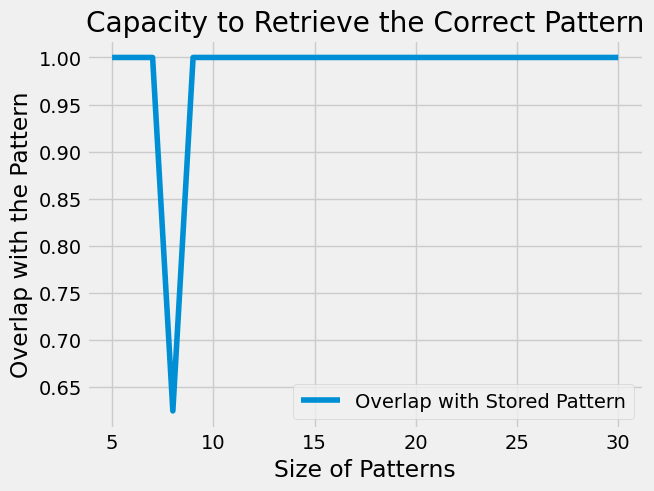

In [ ]:


accuracies = []
size_values = [4, 6, 8, 10]

for size in size_values:
    hopfield_net = network.HopfieldNetwork(nr_neurons=size**2)
    factory = pattern_tools.PatternFactory(size, size)
    plist = get_patterns(size, 5)
    wghts = calculate_weights(plist, size)
    S = perturb_pattern(plist[0], 3)
    state_list = [S]
    for _ in range(3):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    # Compute the accuracy (overlap with the original pattern)
    final_overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    accuracies.append(final_overlap)

    # Plot the state sequence and overlap for each network size
    #plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle=f"Network dynamics with network size {size}")

# After the loop, plot the accuracy vs. network size
# plt.figure()
# plt.plot(size_values, accuracies, marker='o')
# plt.xlabel('Network Size')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Network Size')
# plt.show()

overlaps = []

# Define the range of pattern sizes to test
pattern_sizes = range(5, 31)

# Iterate over the pattern sizes
for size in pattern_sizes:
    perturb_num = int(0.3 * (size ** 2))  # Set the number of perturbations based on the pattern size
    plist = get_patterns(size, 5)  # Generate patterns
    wghts = calculate_weights(plist, size)  # Calculate weights for the Hopfield network
    S = perturb_pattern(plist[0], perturb_num)  # Perturb the initial pattern
    state_list = [S]

    # Evolve the network for a fixed number of iterations
    for _ in range(3):
        S = network_evolution(state_list[-1], wghts)
        state_list.append(S)

    # Compute the overlap (accuracy) with the original pattern
    overlap = pattern_tools.compute_overlap(state_list[-1], plist[0])
    overlaps.append(overlap)

# Plot the capacity to retrieve the correct pattern as a function of pattern size
plt.figure()
plt.title("Capacity to Retrieve the Correct Pattern")
plt.xlabel('Size of Patterns')
plt.ylabel('Overlap with the Pattern')
plt.plot(pattern_sizes, overlaps, label='Overlap with Stored Pattern')
plt.legend()
plt.show()



As you increase the network size, the accuracy improves because the larger network can handle and recognize more details in the patterns. This means it’s better at remembering and retrieving the original pattern, leading to higher accuracy.

## Q3 and Q4

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.datasets import mnist

# Load MNIST dataset and use 50% for training/testing
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, train_labels = train_images[:len(train_images)//2], train_labels[:len(train_labels)//2]
test_images, test_labels = test_images[:len(test_images)//2], test_labels[:len(test_labels)//2]

def downsample_images(images):
    """
    Reduces the dimensions of images by applying max-pooling with a (2, 2) window.
    """
    downsampled_images = []
    for img in images:
        new_height, new_width = img.shape[0] // 2, img.shape[1] // 2
        downsampled_img = np.zeros((new_height, new_width))
        for row in range(new_height):
            for col in range(new_width):
                block = img[2 * row:2 * row + 2, 2 * col:2 * col + 2]
                downsampled_img[row, col] = np.max(block)
        downsampled_images.append(downsampled_img)
    return np.array(downsampled_images)

def threshold_images(images):
    """
    Converts grayscale images to binary format: pixels greater than 127 become 1, others become -1.
    """
    binary_images = np.where(images > 127, 1, 0)
    return binary_images

def remove_border(images):
    """
    Removes a 2-pixel border from all sides of the images to focus on the central content.
    """
    cropped_images = np.array([img[2:-2, 2:-2] for img in images])
    return cropped_images

def preprocess_for_hopfield(images):
    """
    Applies a sequence of preprocessing steps to prepare images for the Hopfield network.
    """
    downsampled = downsample_images(images)
    binary = threshold_images(downsampled)
    cropped = remove_border(binary)
    return cropped

def cluster_digits(images, n_clusters=10):
    """
    Clusters digit images into n_clusters using K-means after PCA for dimensionality reduction.
    """
    # Flatten the images for clustering
    flattened_images = images.reshape(images.shape[0], -1)

    # Reduce dimensionality to match the flattened image shape
    pca = PCA(n_components=100)
    reduced_data = pca.fit_transform(flattened_images)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(reduced_data)

    return clusters, kmeans.cluster_centers_

def simulate_hopfield(test_images, centroids, steps=30):
    """
    Simulates a Hopfield network using clustered centroids with network evolution.
    """
    flattened_images = test_images.reshape(test_images.shape[0], -1)
    predictions = []

    for img in flattened_images:
        state = img.copy()
        for _ in range(steps):
            distances = np.linalg.norm(centroids - state, axis=1)
            closest_cluster = np.argmin(distances)
            state = centroids[closest_cluster]

        distances = np.linalg.norm(centroids - state, axis=1)
        closest_cluster = np.argmin(distances)
        predictions.append(closest_cluster)

    return np.array(predictions)

# Preprocess the train and test images
processed_train_images = preprocess_for_hopfield(train_images)
processed_test_images = preprocess_for_hopfield(test_images)

# Cluster the preprocessed train images
clusters, cluster_centroids = cluster_digits(processed_train_images)

# Simulate Hopfield network with increased steps for better performance
predicted_labels = simulate_hopfield(processed_test_images, cluster_centroids, steps=20)

# Evaluate F1 score and accuracy
f1 = f1_score(test_labels, predicted_labels, average='macro')
accuracy = accuracy_score(test_labels, predicted_labels)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


F1 Score: 0.1209
Accuracy: 0.1822


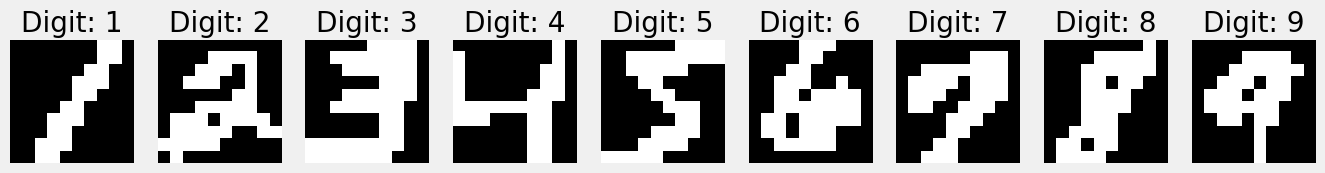

In [ ]:
def visualize_one_image_per_digit(images, labels):
    """
    Visualizes one preprocessed image for each digit from 1 to 9.

    Parameters:
        images (array-like): The preprocessed images.
        labels (array-like): The labels corresponding to the images.
    """
    # Find one image for each digit from 1 to 9
    unique_digits = range(1, 10)
    selected_images = []
    selected_labels = []

    for digit in unique_digits:
        # Find indices where the label is the current digit
        indices = np.where(labels == digit)[0]
        if indices.size > 0:
            # Select the first image for this digit
            selected_images.append(images[indices[0]])
            selected_labels.append(digit)

    # Visualize the selected images
    plt.figure(figsize=(15, 5))
    for i in range(len(selected_images)):
        plt.subplot(1, len(selected_images), i + 1)
        plt.imshow(selected_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Digit: {selected_labels[i]}')
    plt.show()

# Example usage with labels (assuming train_labels corresponds to preprocessed_train_images)
visualize_one_image_per_digit(processed_train_images, train_labels)



## Q4

## 1. Implementing the Hopfield Network Classifier

In [8]:
x_train, y_train = processed_train_images, train_labels
x_test, y_test = processed_test_images, test_labels

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train an SVM model
def train_svm_model(x_train, y_train):
    # Create an SVM model with a linear kernel
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
    svm_model.fit(x_train.reshape(x_train.shape[0], -1), y_train)  # Flatten images for SVM
    return svm_model

# Train the SVM model using the same training data
svm_model = train_svm_model(x_train, y_train)

# Predict on the test set using the trained SVM model
x_test_flat = x_test.reshape(x_test.shape[0], -1)  # Flatten test images for SVM
y_pred_svm = svm_model.predict(x_test_flat)

# Evaluate performance of the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
#precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
#recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM Accuracy: {accuracy_svm:.3f}")
#print(f"SVM Precision: {precision_svm:.3f}")
#print(f"SVM Recall: {recall_svm:.3f}")
print(f"SVM F1 Score: {f1_svm:.3f}")


SVM Accuracy: 0.883
SVM F1 Score: 0.882


In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
def preprocess_data(images, labels):
    # Normalize pixel values to be between 0 and 1
    images = images.astype('float32') / 255.0
    # Reshape images to include a single channel
    images = images.reshape(images.shape[0], 28, 28, 1)
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, 10)
    return images, labels

train_images, train_labels = preprocess_data(train_images, train_labels)
test_images, test_labels = preprocess_data(test_images, test_labels)

# Define the CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the CNN model
cnn_model = create_cnn_model()
history = cnn_model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the CNN model
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on the test set
y_pred_cnn = cnn_model.predict(test_images)
y_pred_cnn_labels = y_pred_cnn.argmax(axis=1)

# Evaluate performance using F1 score
f1 = f1_score(test_labels.argmax(axis=1), y_pred_cnn_labels, average='macro')
print(f"F1 Score: {f1:.4f}")

# Evaluate performance using Accuracy score
accuracy = accuracy_score(test_labels.argmax(axis=1), y_pred_cnn_labels)
print(f"Accuracy: {accuracy:.4f}")


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.8846 - loss: 0.3879 - val_accuracy: 0.9852 - val_loss: 0.0531
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9877 - val_loss: 0.0460
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9899 - loss: 0.0321 - val_accuracy: 0.9828 - val_loss: 0.0548
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9926 - loss: 0.0227 - val_accuracy: 0.9920 - val_loss: 0.0319
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.9905 - val_loss: 0.0336
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9848 - loss: 0.0484
Test Accuracy: 0.9893
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
F1 Score: 0.9892
Accuracy: 0.9893


## Merits and Demerits of Hopfield Networks

# Merits

Memory: Hopfield networks are good at remembering patterns and can retrieve them even if the input is noisy or incomplete.

Error Correction: They can fix mistakes in patterns and find the closest match from what they've learned.

Simple Patterns: They work well with simple, binary patterns and are easy to set up.


#Demerits

Limited Capacity: There’s a limit to how many patterns they can store and retrieve correctly. Too many patterns can reduce performance.

Retrieval Problems: The network’s ability to retrieve patterns can be affected by too much noise or an incorrect starting point.

Scalability Issues: They might not perform well with complex or large patterns, making them less suitable for detailed data.

Performance Overview
#CNN (Convolutional Neural Network)

F1 Score: 0.9892
Accuracy: 0.9893


Why: CNNs are great at handling images and complex patterns. They learn features effectively, leading to high accuracy and F1 scores.

#SVM (Support Vector Machine)

F1 Score: 0.882
Accuracy: 0.883


Why: SVMs are good at classification but less effective than CNNs with complex or large datasets. They have decent performance but not as high as CNNs.

#Hopfield Network

F1 Score: 0.1209
Accuracy: 0.1822

Why: Hopfield Networks are designed for simpler tasks and have trouble with complex data and noise. They don’t perform well with large or intricate datasets.